In [ ]:
# Data
import numpy as np
import pandas as pd

# Plot
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Pipeline
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import RobustScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline

# Models
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

# Validation
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SelectPercentile, mutual_info_regression, SelectFromModel
from scipy import stats
import statsmodels.api as sm

# Others
import joblib
from datetime import datetime
import os
import yfinance as yf
from bs4 import BeautifulSoup
import requests
import re

In [3]:
def download_and_concat_tickers(tickers, start_date=None, end_date=None, interval='1d'):
    """Download data of provided tickers for the specified interval"""
    if start_date:
        df = yf.download(tickers, start=start_date, end=end_date, interval=interval)
    else:
        df = yf.download(tickers, period="max", interval=interval)

    df.columns = [f"{ticker}_{field}" for field, ticker in df.columns]

    return df

tickers = [
    "^GSPC", "^DJI", "^VIX", "^GVZ", "^OVX", "^MOVE", "BOND", "^STOXX",
    "EURUSD=X", "DX-Y.NYB", "CL=F", "BZ=F", "SI=F", "PL=F", "BTC-USD", "JPM",
    "PA=F", "^TNX", "GC=F", "GDX", "EGO", "USO", "GD=F",
]

result_df = download_and_concat_tickers(tickers, start_date="2000-08-30", end_date="2025-12-11")
result_df.tail()

/tmp/ipykernel_119156/2686361912.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(tickers, start=start_date, end=end_date, interval=interval)
[*********************100%***********************]  23 of 23 completed


,BOND_Close,BTC-USD_Close,BZ=F_Close,CL=F_Close,DX-Y.NYB_Close,EGO_Close,EURUSD=X_Close,GC=F_Close,GD=F_Close,GDX_Close,...,SI=F_Volume,USO_Volume,^DJI_Volume,^GSPC_Volume,^GVZ_Volume,^MOVE_Volume,^OVX_Volume,^STOXX_Volume,^TNX_Volume,^VIX_Volume
Date,,,,,,,,,,,,,,,,,,,,,
2025-12-06,NaN,89272.375000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-12-07,NaN,90405.640625,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-12-08,92.959999,90640.203125,62.490002,58.880001,99.089996,30.870001,1.164022,4187.200195,556.349976,79.160004,...,518.0,3073400.0,505490000.0,4.757130e+09,0.0,0.0,0.0,159308700.0,0.0,0.0
2025-12-09,92.879997,92691.710938,61.939999,58.250000,99.220001,32.360001,1.164144,4206.700195,552.299988,81.940002,...,324.0,3111300.0,425470000.0,4.508050e+09,0.0,0.0,0.0,170040500.0,0.0,0.0
2025-12-10,93.199997,92020.945312,62.209999,58.459999,98.790001,33.570000,1.162831,4196.399902,554.200012,83.320000,...,462.0,8096000.0,545610000.0,5.526570e+09,0.0,0.0,0.0,209327200.0,0.0,0.0


In [ ]:
# Save csv
#result_df.to_csv("../raw_data/new_data.csv")

                                 Open        High         Low       Close  \
Date                                                                        
2000-08-30 00:00:00-04:00  273.899994  273.899994  273.899994  273.899994   
2000-08-31 00:00:00-04:00  274.799988  278.299988  274.799988  278.299988   
2000-09-01 00:00:00-04:00  277.000000  277.000000  277.000000  277.000000   
2000-09-05 00:00:00-04:00  275.799988  275.799988  275.799988  275.799988   
2000-09-06 00:00:00-04:00  274.200012  274.200012  274.200012  274.200012   

                           Volume  Dividends  Stock Splits  
Date                                                        
2000-08-30 00:00:00-04:00       0        0.0           0.0  
2000-08-31 00:00:00-04:00       0        0.0           0.0  
2000-09-01 00:00:00-04:00       0        0.0           0.0  
2000-09-05 00:00:00-04:00       2        0.0           0.0  
2000-09-06 00:00:00-04:00       0        0.0           0.0  


<Axes: title={'center': 'Gold Price (Daily)'}, xlabel='Date'>

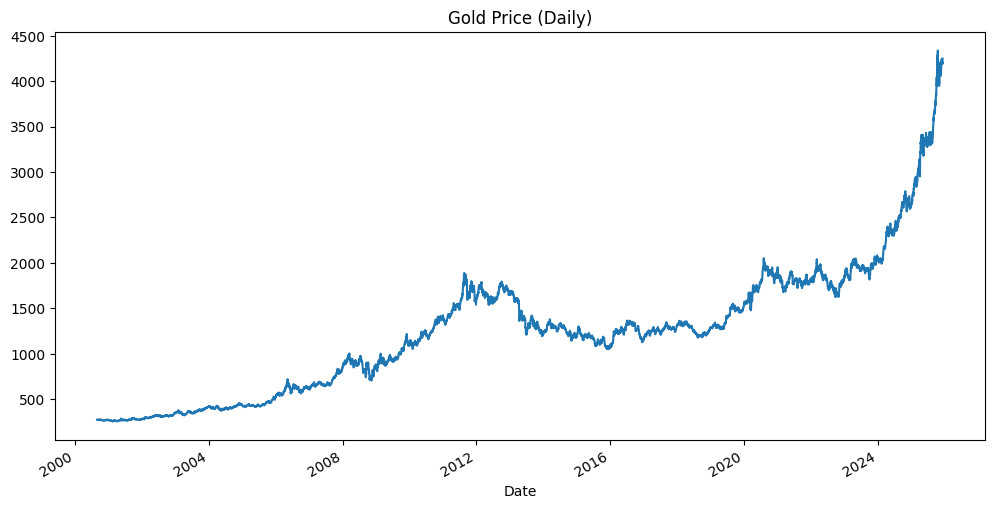

In [33]:
# Get the history of a ticker
gold = yf.Ticker("GC=F")
data = gold.history(period="max", interval="1d")
df_gold = pd.DataFrame(data)
print(df_gold.head())
df_gold["Close"].plot(title="Gold Price (Daily)", figsize=(12, 6))

In [84]:
result_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7750 entries, 2000-08-30 to 2025-12-10
Columns: 115 entries, BOND_Close to ^VIX_Volume
dtypes: float64(115)
memory usage: 6.9 MB


In [85]:
result_df.describe()

,BOND_Close,BTC-USD_Close,BZ=F_Close,CL=F_Close,DX-Y.NYB_Close,EGO_Close,EURUSD=X_Close,GC=F_Close,GD=F_Close,GDX_Close,...,SI=F_Volume,USO_Volume,^DJI_Volume,^GSPC_Volume,^GVZ_Volume,^MOVE_Volume,^OVX_Volume,^STOXX_Volume,^TNX_Volume,^VIX_Volume
count,3466.000000,4102.000000,4571.000000,6348.000000,6384.000000,5759.000000,5716.000000,6344.000000,4963.000000,4921.000000,...,6346.000000,4.950000e+03,6.358000e+03,6.358000e+03,4410.0,5705.0,4678.0,5.442000e+03,6352.000000,6358.0
mean,79.774140,26519.151504,78.100457,64.705819,92.493261,26.263302,1.225024,1244.762578,517.302402,31.761441,...,1454.892531,3.043678e+06,2.610088e+08,3.479556e+09,0.0,0.0,0.0,1.295728e+08,1030.588791,0.0
std,7.909687,31413.340581,23.820727,24.603556,11.203539,22.465491,0.127433,715.204490,119.185226,11.616030,...,8444.163998,4.018551e+06,1.334033e+08,1.480125e+09,0.0,0.0,0.0,1.272028e+08,12659.711272,0.0
min,61.905201,178.102997,19.330000,-37.630001,71.330002,2.640000,0.959619,255.100006,230.300003,11.390458,...,0.000000,1.488800e+04,8.410000e+06,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.000000,0.0
25%,73.665110,2656.817383,61.139999,46.317500,82.510002,10.835000,1.117197,648.400024,419.779999,21.883282,...,5.000000,1.029203e+06,1.707725e+08,2.492902e+09,0.0,0.0,0.0,0.000000e+00,0.000000,0.0
50%,78.926388,10667.725586,75.550003,63.809999,92.920002,17.120001,1.207700,1247.549988,523.549988,30.637808,...,36.000000,2.296969e+06,2.469150e+08,3.563250e+09,0.0,0.0,0.0,1.591713e+08,0.000000,0.0
75%,86.427841,41783.284180,97.750000,81.964998,99.589996,33.144140,1.320228,1675.674988,613.399994,38.893032,...,142.000000,3.993554e+06,3.244725e+08,4.280720e+09,0.0,0.0,0.0,2.211025e+08,0.000000,0.0
max,93.749237,124752.531250,146.080002,145.289993,120.900002,105.309471,1.598798,4336.399902,886.799988,84.440002,...,170297.000000,1.249130e+08,1.412960e+09,1.145623e+10,0.0,0.0,0.0,1.109144e+09,159700.000000,0.0


In [87]:
# NaN check
result_df.isna().sum() / len(result_df) * 100

BOND_Close        55.277419
BTC-USD_Close     47.070968
BZ=F_Close        41.019355
CL=F_Close        18.090323
DX-Y.NYB_Close    17.625806
                    ...    
^MOVE_Volume      26.387097
^OVX_Volume       39.638710
^STOXX_Volume     29.780645
^TNX_Volume       18.038710
^VIX_Volume       17.961290
Length: 115, dtype: float64

In [4]:
def clean_name(name: str):
    s = str(name)

    # 1) remove leading non-alphanumeric characters (anything not [A-Za-z0-9])
    s = re.sub(r'^[^A-Za-z0-9]+', '', s)

    # 2) replace any remaining non-word characters with underscores
    # \w = [A-Za-z0-9_]; anything else becomes '_'
    s = re.sub(r'\W+', '_', s)

    # 3) collapse multiple underscores
    s = re.sub(r'_+', '_', s)

    # 4) strip trailing underscores (optional but tidy)
    s = s.strip('_')

    return s

In [5]:
# --- Preprocessing ---
# Drop NaN based on gold price
result_df = result_df.dropna(how='any', subset=["GC=F_Close"], axis=0)

# Replace special characters in columns name
result_df.columns = [clean_name(c) for c in result_df.columns]

In [6]:
result_df.head()

,BOND_Close,BTC_USD_Close,BZ_F_Close,CL_F_Close,DX_Y_NYB_Close,EGO_Close,EURUSD_X_Close,GC_F_Close,GD_F_Close,GDX_Close,...,SI_F_Volume,USO_Volume,DJI_Volume,GSPC_Volume,GVZ_Volume,MOVE_Volume,OVX_Volume,STOXX_Volume,TNX_Volume,VIX_Volume
Date,,,,,,,,,,,,,,,,,,,,,
2000-08-30,NaN,NaN,NaN,33.400002,112.139999,NaN,NaN,273.899994,NaN,NaN,...,2319.0,NaN,146490000.0,8.184000e+08,NaN,NaN,NaN,NaN,0.0,0.0
2000-08-31,NaN,NaN,NaN,33.099998,112.599998,NaN,NaN,278.299988,NaN,NaN,...,1612.0,NaN,183320000.0,1.056600e+09,NaN,NaN,NaN,NaN,0.0,0.0
2000-09-01,NaN,NaN,NaN,33.380001,111.419998,NaN,NaN,277.000000,NaN,NaN,...,1375.0,NaN,125140000.0,7.677000e+08,NaN,NaN,NaN,NaN,0.0,0.0
2000-09-05,NaN,NaN,NaN,33.799999,112.410004,NaN,NaN,275.799988,NaN,NaN,...,856.0,NaN,174500000.0,8.385000e+08,NaN,NaN,NaN,NaN,0.0,0.0
2000-09-06,NaN,NaN,NaN,34.950001,114.120003,NaN,NaN,274.200012,NaN,NaN,...,232.0,NaN,224760000.0,9.951000e+08,NaN,NaN,NaN,NaN,0.0,0.0


In [7]:
def chronological_split(X, y, train_ratio=0.7):
    """Chronological split (no shuffle). Returns X_train, X_val, y_train, y_val."""
    X = X.sort_index()
    y = y.loc[X.index]
    split_idx = int(np.floor(len(X) * train_ratio))
    return X.iloc[:split_idx], X.iloc[split_idx:], y.iloc[:split_idx], y.iloc[split_idx:]

def evaluate_metrics(y_true, y_pred, prefix=""):
    """Compute MAE, RMSE, R2 and print them."""
    mae = mean_absolute_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{prefix} MAE={mae:.6f} | RMSE={rmse:.6f} | R2={r2:.6f}")
    return {"MAE": mae, "RMSE": rmse, "R2": r2}

def learning_curves_time_series(estimator, X, y, train_sizes, n_splits=5, scoring='rmse'):
    """
    Time-series learning curves: for increasing train sizes, use TimeSeriesSplit folds.
    Returns arrays of avg train and validation scores.
    """
    train_scores = []
    val_scores = []

    for ts in train_sizes:
        X_sub = X.iloc[:ts]
        y_sub = y.iloc[:ts]

        tscv = TimeSeriesSplit(n_splits=n_splits)
        fold_train_scores, fold_val_scores = [], []

        for tr_idx, va_idx in tscv.split(X_sub):
            X_tr, X_va = X_sub.iloc[tr_idx], X_sub.iloc[va_idx]
            y_tr, y_va = y_sub.iloc[tr_idx], y_sub.iloc[va_idx]

            est = clone(estimator)
            est.fit(X_tr, y_tr)

            y_tr_pred = est.predict(X_tr)
            y_va_pred = est.predict(X_va)

            if scoring == 'rmse':
                tr = root_mean_squared_error(y_tr, y_tr_pred)
                va = root_mean_squared_error(y_va, y_va_pred)
            elif scoring == 'mae':
                tr = mean_absolute_error(y_tr, y_tr_pred)
                va = mean_absolute_error(y_va, y_va_pred)
            elif scoring == 'r2':
                tr = r2_score(y_tr, y_tr_pred)
                va = r2_score(y_va, y_va_pred)
            else:
                raise ValueError("Unsupported scoring")

            fold_train_scores.append(tr)
            fold_val_scores.append(va)

        train_scores.append(np.mean(fold_train_scores))
        val_scores.append(np.mean(fold_val_scores))

    return np.array(train_scores), np.array(val_scores)


In [ ]:
class PrePreprocessTransformer(BaseEstimator, TransformerMixin):
    """
    Drop columns mostly fill of 0
    """
    def __init__(self, threshold=0.9, exclude=None):
        self.threshold = threshold
        self.exclude = exclude or []
        self._drop_cols_ = None  # learned set of columns to drop

    def fit(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            raise TypeError("PrePreprocessTransformer expects a pandas DataFrame in fit.")

        # Work on a copy to avoid mutation
        df = X.copy()

        # Restrict to numeric columns (excluding any explicitly protected ones)
        num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        num_cols = [c for c in num_cols if c not in self.exclude]

        # Compute zero ratio per column using non-NA counts
        zero_ratio = (df[num_cols] == 0).sum() / df[num_cols].count()

        # Columns to drop, learned from training data
        self._drop_cols_ = zero_ratio[zero_ratio >= self.threshold].index.tolist()
        return self

    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            raise TypeError("PrePreprocessTransformer expects a pandas DataFrame in transform.")

        if self._drop_cols_ is None:
            raise RuntimeError("Transformer not fitted. Call fit before transform.")

        # Drop the learned columns (ignore missing ones gracefully)
        return X.drop(columns=[c for c in self._drop_cols_ if c in X.columns], axis=1)

    def set_output(self, *, transform=None):
        # compatibility with sklearn's set_output API
        return self


class CustomPreprocessTransformer(BaseEstimator, TransformerMixin):
    """
     Fill NaN based on a custom strategy:
    - if gap at the begining, fill with the first known value
    - if gap in the middle, linear interpolation
    - if gap at the end, fill with the last known value
    """
    def __init__(self, method='linear', drop_all_nan=False):
        self.method = method
        self.drop_all_nan = drop_all_nan

    def fit(self, X, y=None):
        # Nothing to learn
        return self

    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            raise TypeError("PreprocessEngineeringTransformer expects a pandas DataFrame.")

        X = X.copy()

        # Select the columns
        numeric_cols = X.select_dtypes(include=[np.number]).columns

        # Fill NaN strategy
        X[numeric_cols] = (
            X[numeric_cols].interpolate(method=self.method, axis=0, limit_direction="both")
        )

        # Drop columns of full NaN
        if self.drop_all_nan:
            all_nan_cols = [c for c in numeric_cols if X[c].isna().all()]
            if all_nan_cols:
                X = X.drop(columns=all_nan_cols)

        return X

    def set_output(self, *, transform=None):
        # No-op to be compatible with pipelines calling set_output
        return self


class CustomFeatureSelector(BaseEstimator, TransformerMixin):
    """
    Drop highly correlated numerical features (> threshold) based on upper triangle of correlation matrix.
    """
    def __init__(self, num_corr_threshold=0.95, method='pearson'):
        self.num_corr_threshold = num_corr_threshold
        self.method = method

    def fit(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            raise TypeError("CustomFeatureSelector expects a pandas DataFrame.")
        self.num_cols_ = list(X.select_dtypes(include=[np.number]).columns)
        if len(self.num_cols_) == 0:
            self.num_col_to_drop_ = []
            return self
        corr_num = X[self.num_cols_].corr(method=self.method)
        upper = corr_num.where(np.triu(np.ones(corr_num.shape), k=1).astype(bool)).abs()
        self.num_col_to_drop_ = [c for c in upper.columns if any(upper[c] > self.num_corr_threshold)]
        return self

    def transform(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            raise TypeError("CustomFeatureSelector expects a pandas DataFrame.")
        return X.drop(columns=getattr(self, 'num_col_to_drop_', []), errors='ignore')

    def set_output(self, *, transform=None):
        # No-op to be compatible with pipelines calling set_output
        return self

In [18]:
def build_preprocessing_pipeline(
    num_corr_threshold=0.95,
    method='linear',
    remove_features=False,
    strategy="custom",
    exclude_for_zero_drop=None
):
    exclude_for_zero_drop = exclude_for_zero_drop or []
    num_selector = make_column_selector(dtype_include=np.number)
    #cat_selector = make_column_selector(dtype_include=["object", "category"])

    if strategy == "custom":
        pre_steps = Pipeline([
            ("preprocess", PrePreprocessTransformer(exclude=exclude_for_zero_drop)),
            ("imputer", CustomPreprocessTransformer(method=method)),
        ]).set_output(transform="pandas")

        numeric_block = Pipeline([
            ("scaler", RobustScaler())
        ])

        preprocessor = Pipeline([
            ("pre_custom", pre_steps),
            ("ct", ColumnTransformer(
                transformers=[("num", numeric_block, num_selector),
                              #("cat", OrdinalEncoder(handle_unknown="ignore"), cat_selector),
                              ],
                remainder="drop"
            ).set_output(transform="pandas"))
        ]).set_output(transform="pandas")

    elif strategy == "mean":
        numeric_block = Pipeline([
            ("imputer", SimpleImputer(strategy="mean")),
            ("scaler", RobustScaler())
        ])

        preprocessor = ColumnTransformer(
            transformers=[("num", numeric_block, num_selector),
                          #("cat", OrdinalEncoder(handle_unknown="ignore"), cat_selector),
                          ],
            remainder="drop"
        ).set_output(transform="pandas")

    elif strategy == "median":
        numeric_block = Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", RobustScaler())
        ])

        preprocessor = ColumnTransformer(
            transformers=[("num", numeric_block, num_selector),
                          #("cat", OrdinalEncoder(handle_unknown="ignore"), cat_selector),
                          ],
            remainder="drop"
        ).set_output(transform="pandas")

    else:
        raise TypeError("Strategy not correct")

    if remove_features:
        pipe_new = Pipeline(steps=[
            ("preprocessor", preprocessor),
            ("corr_feature_dropper", CustomFeatureSelector(num_corr_threshold=num_corr_threshold, method='pearson')),
        ]).set_output(transform="pandas")
    else:
        pipe_new = Pipeline(steps=[
            ("preprocessor", preprocessor),
        ]).set_output(transform="pandas")

    return pipe_new

In [10]:
# --- Settings ---
horizon_day=1
train_ratio=0.7
num_corr_threshold=0.95
plot_learning_curves=True
strategy="custom" # median, mean

target_source_col = 'GC_F_Close'

In [11]:
# --- Features and target ---
df = result_df.sort_index().copy()
target_col = f"{target_source_col}_t+{horizon_day}"
df[target_col] = df[target_source_col].shift(-horizon_day)

# Drop values of the shift
df = df.dropna(subset=[target_col])

# Set close column as first column
cols = list(df.columns)
cols.remove(target_source_col)
cols.insert(0, target_source_col)
df = df[cols]

feature_cols = df.drop(columns=target_col).columns
X = df[feature_cols]
y = df[target_col]

In [14]:
# --- Split ---
X_train, X_val, y_train, y_val = chronological_split(X, y, train_ratio)

In [19]:
# --- Preprocessing pipeline ---
pipe_new = build_preprocessing_pipeline(strategy=strategy, exclude_for_zero_drop=['GC_F_Close']) # mean, median
pipe_new

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('pre_custom',
                                  Pipeline(steps=[('preprocess',
                                                   PrePreprocessTransformer(exclude=['GC_F_Close'])),
                                                  ('imputer',
                                                   CustomPreprocessTransformer())])),
                                 ('ct',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('scaler',
                                                                                    RobustScaler())]),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x7aa670762e60>)]))]))])

In [32]:
# --- Fit preprocessing ---
X_train_proc = pipe_new.fit_transform(X_train, y_train)
X_val_proc = pipe_new.transform(X_val)

/home/theo/.pyenv/versions/3.10.6/envs/Forecasting-Gold-Price/lib/python3.10/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


In [33]:
display(X_train_proc, X_val_proc)

,num__GC_F_Close,num__BOND_Close,num__BTC_USD_Close,num__BZ_F_Close,num__CL_F_Close,num__DX_Y_NYB_Close,num__EGO_Close,num__EURUSD_X_Close,num__GD_F_Close,num__GDX_Close,...,num__GD_F_Volume,num__GDX_Volume,num__JPM_Volume,num__PA_F_Volume,num__PL_F_Volume,num__SI_F_Volume,num__USO_Volume,num__DJI_Volume,num__GSPC_Volume,num__STOXX_Volume
Date,,,,,,,,,,,,,,,,,,,,,
2000-08-30,-0.802701,0.000000,0.000000,0.000000,-0.584228,1.673239,-0.592941,-0.390457,0.000000,0.000000,...,0.000000,-0.264495,-0.382298,0.012048,1.341434,17.875000,-0.121211,-0.479313,-1.055047,0.000000
2000-08-31,-0.797579,0.000000,0.000000,0.000000,-0.590800,1.702973,-0.592941,-0.390457,0.000000,0.000000,...,0.000000,-0.264495,-0.377564,0.012048,0.557311,12.351562,-0.121211,-0.202641,-0.950248,0.000000
2000-09-01,-0.799092,0.000000,0.000000,0.000000,-0.584666,1.626697,-0.592941,-0.390457,0.000000,0.000000,...,0.000000,-0.264495,-0.546058,-0.048193,1.137303,10.500000,-0.121211,-0.639698,-1.077353,0.000000
2000-09-05,-0.800489,0.000000,0.000000,0.000000,-0.575466,1.690692,-0.592941,-0.390457,0.000000,0.000000,...,0.000000,-0.264495,-0.581621,-0.060241,1.858242,6.445312,-0.121211,-0.268898,-1.046204,0.000000
2000-09-06,-0.802351,0.000000,0.000000,0.000000,-0.550274,1.801228,-0.592941,-0.390457,0.000000,0.000000,...,0.000000,-0.264495,-0.469898,-0.060241,1.378696,1.570312,-0.121211,0.108663,-0.977306,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-05-11,0.413805,2.031661,7984.156219,0.063194,0.232859,0.406270,-0.689060,-0.422650,0.295269,-0.857302,...,7.576512,0.708190,-0.275383,-0.060241,-0.021061,0.351562,0.848793,0.479689,-0.150287,1.071905
2018-05-14,0.410895,2.027734,8259.456024,0.114024,0.238554,0.409502,-0.689060,-0.399182,0.312638,-0.864704,...,2.644128,0.806871,-0.362819,-0.060241,-0.022681,0.281250,1.057839,0.545120,-0.097707,1.013106
2018-05-15,0.378769,1.989453,8053.045868,0.123183,0.246221,0.450226,-0.689060,-0.413395,0.313674,-0.903196,...,2.316726,2.080140,-0.202636,-0.060241,-0.022681,0.703125,1.212893,0.688151,0.032887,1.309800


,num__GC_F_Close,num__BOND_Close,num__BTC_USD_Close,num__BZ_F_Close,num__CL_F_Close,num__DX_Y_NYB_Close,num__EGO_Close,num__EURUSD_X_Close,num__GD_F_Close,num__GDX_Close,...,num__GD_F_Volume,num__GDX_Volume,num__JPM_Volume,num__PA_F_Volume,num__PL_F_Volume,num__SI_F_Volume,num__USO_Volume,num__DJI_Volume,num__GSPC_Volume,num__STOXX_Volume
Date,,,,,,,,,,,,,,,,,,,,,
2018-05-18,0.380282,1.976697,7793.635712,0.126846,0.245564,0.477376,-0.679547,-0.505565,0.324217,-0.908378,...,0.217082,0.547214,-0.187324,-0.060241,-0.022681,0.015625,0.695385,0.446260,0.073399,1.490090
2018-05-21,0.380282,1.989453,7961.656219,0.159359,0.266594,0.479961,-0.689060,-0.524950,0.350423,-0.898014,...,0.124555,0.663822,-0.321366,-0.060241,-0.022681,-0.125000,0.790272,0.740887,-0.071696,1.351854
2018-05-22,0.382028,1.984549,7584.445770,0.175386,0.264184,0.475437,-0.658619,-0.507451,0.355908,-0.912819,...,0.366548,0.879236,-0.204258,-0.060241,-0.022681,0.320312,1.382328,0.585235,0.073782,1.213617
2018-05-23,0.379234,2.011051,7100.485809,0.185919,0.257831,0.501293,-0.651008,-0.510091,0.355908,-0.897274,...,0.092527,1.104947,-0.207302,-0.060241,-0.022681,0.000000,1.041184,1.422165,0.051352,1.277463
2018-05-24,0.395996,2.029700,7130.005829,0.139668,0.233078,0.486425,-0.651008,-0.563252,0.338234,-0.874327,...,0.220641,1.404736,-0.058152,-0.060241,-0.022681,6.289062,0.980502,1.027325,0.030494,1.250504
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-12-03,3.766500,4.107035,93070.470673,-0.598512,-0.024534,0.814156,0.300297,-0.619013,0.735583,3.946661,...,0.000000,0.406326,-0.372762,0.132530,-0.022681,1.820312,1.926028,2.104043,0.668892,1.016504
2025-12-04,3.781050,4.083637,91684.290985,-0.571494,-0.008762,0.823206,0.320846,-0.592615,0.758132,3.973114,...,0.010676,0.201841,-0.310827,0.054217,-0.022681,2.375000,2.522871,2.166845,0.728577,1.038416
2025-12-05,3.782330,4.070638,88930.423798,-0.549055,0.000219,0.823206,0.313616,-0.608915,0.786166,3.944257,...,0.359431,0.406446,-0.487076,0.114458,-0.022681,1.976562,2.801612,1.846527,0.760307,0.906987


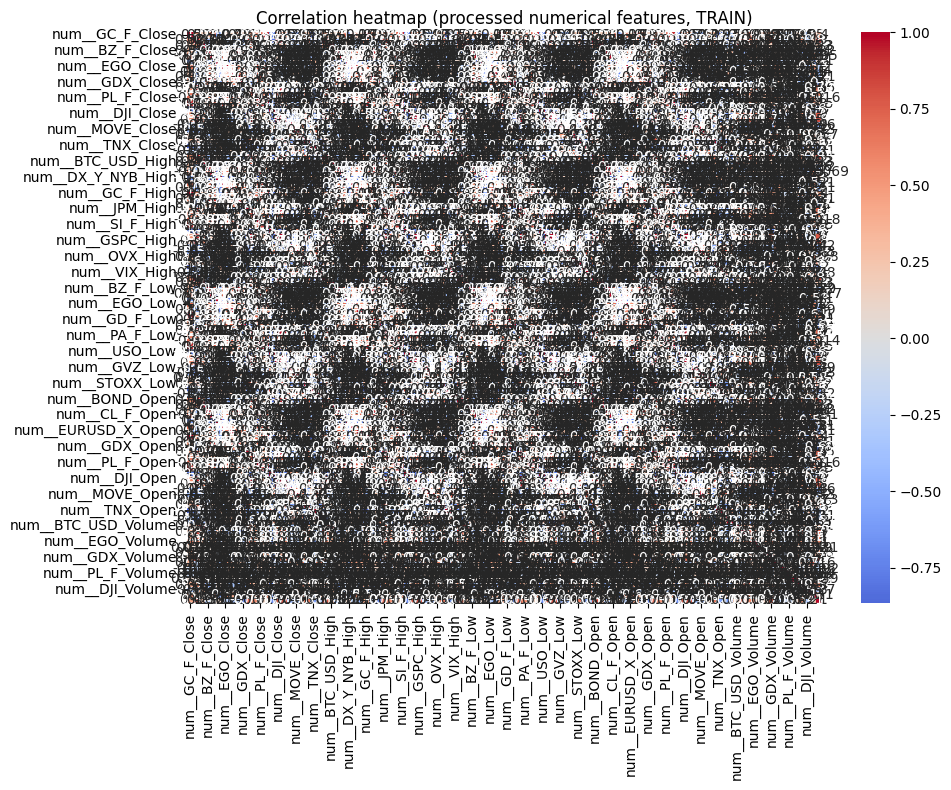

In [34]:
# --- Correlation check ---
processed_feature_names = X_train_proc.columns
num_names = [n for n in processed_feature_names if n.startswith('num__')]
num_idx = [list(processed_feature_names).index(n) for n in num_names]
X_train_num_df = pd.DataFrame(X_train_proc.iloc[:, num_idx], index=X_train.index, columns=num_names)

plt.figure(figsize=(10, 8))
sns.heatmap(X_train_num_df.corr(), cmap='coolwarm', center=0, annot=True)
plt.title('Correlation heatmap (processed numerical features, TRAIN)')
plt.tight_layout(); plt.show()

In [35]:
# --- Automatic clean pipe ---
pipe_auto = build_preprocessing_pipeline(remove_features=True, strategy=strategy, exclude_for_zero_drop=['GC_F_Close']) # mean, median
pipe_auto

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('pre_custom',
                                  Pipeline(steps=[('preprocess',
                                                   PrePreprocessTransformer(exclude=['GC_F_Close'])),
                                                  ('imputer',
                                                   CustomPreprocessTransformer())])),
                                 ('ct',
                                  ColumnTransformer(transformers=[('num',
                                                                   Pipeline(steps=[('scaler',
                                                                                    RobustScaler())]),
                                                                   <sklearn.compose._column_transformer.make_column_selector object at 0x7aa611dcfa90>)]))])),
                ('corr_feature_dropper', CustomFeatureSelector())])

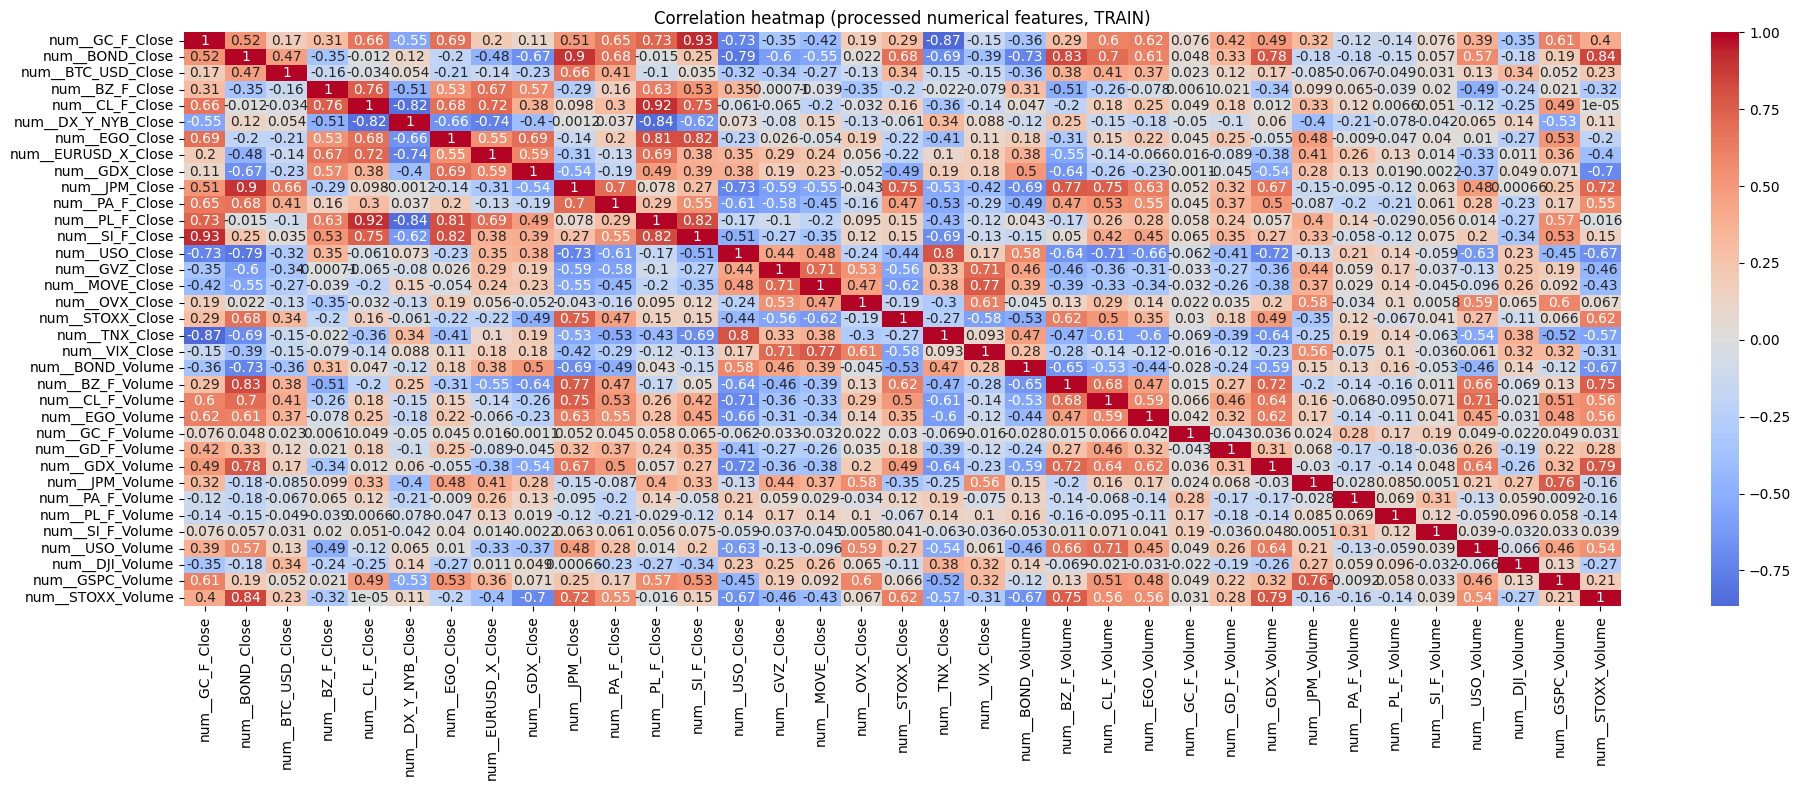

In [39]:
# --- Correlation check of preproc ---
X_train_proc = pipe_auto.fit_transform(X_train, y_train)

plt.figure(figsize=(20, 8))
sns.heatmap(X_train_proc.corr(), cmap='coolwarm', center=0, annot=True)
plt.title('Correlation heatmap (processed numerical features, TRAIN)')
plt.tight_layout(); plt.show()

In [40]:
# List of dropped columns from the selector (pre-drop raw names)
dropper = pipe_auto.named_steps['corr_feature_dropper']
print("Correlated numeric features dropped by selector:", getattr(dropper, 'num_col_to_drop_', []))

Correlated numeric features dropped by selector: ['num__GD_F_Close', 'num__DJI_Close', 'num__GSPC_Close', 'num__BOND_High', 'num__BTC_USD_High', 'num__BZ_F_High', 'num__CL_F_High', 'num__DX_Y_NYB_High', 'num__EGO_High', 'num__EURUSD_X_High', 'num__GC_F_High', 'num__GD_F_High', 'num__GDX_High', 'num__JPM_High', 'num__PA_F_High', 'num__PL_F_High', 'num__SI_F_High', 'num__USO_High', 'num__DJI_High', 'num__GSPC_High', 'num__GVZ_High', 'num__MOVE_High', 'num__OVX_High', 'num__STOXX_High', 'num__TNX_High', 'num__VIX_High', 'num__BOND_Low', 'num__BTC_USD_Low', 'num__BZ_F_Low', 'num__CL_F_Low', 'num__DX_Y_NYB_Low', 'num__EGO_Low', 'num__EURUSD_X_Low', 'num__GC_F_Low', 'num__GD_F_Low', 'num__GDX_Low', 'num__JPM_Low', 'num__PA_F_Low', 'num__PL_F_Low', 'num__SI_F_Low', 'num__USO_Low', 'num__DJI_Low', 'num__GSPC_Low', 'num__GVZ_Low', 'num__MOVE_Low', 'num__OVX_Low', 'num__STOXX_Low', 'num__TNX_Low', 'num__VIX_Low', 'num__BOND_Open', 'num__BTC_USD_Open', 'num__BZ_F_Open', 'num__CL_F_Open', 'num__DX

In [41]:
# --- Final model pipeline ---
model = LinearRegression()

pipe_auto = build_preprocessing_pipeline(remove_features=True, strategy=strategy, exclude_for_zero_drop=['GC_F_Close']) # mean, median

pipe = Pipeline(steps=[
    ('preprocessing', pipe_auto),
    ('model', model)
])
print(pipe)

pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('preprocessor',
                                  Pipeline(steps=[('pre_custom',
                                                   Pipeline(steps=[('preprocess',
                                                                    PrePreprocessTransformer(exclude=['GC_F_Close'])),
                                                                   ('imputer',
                                                                    CustomPreprocessTransformer())])),
                                                  ('ct',
                                                   ColumnTransformer(transformers=[('num',
                                                                                    Pipeline(steps=[('scaler',
                                                                                                     RobustScaler())]),
                                                                                    <skle

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('preprocessor',
                                  Pipeline(steps=[('pre_custom',
                                                   Pipeline(steps=[('preprocess',
                                                                    PrePreprocessTransformer(exclude=['GC_F_Close'])),
                                                                   ('imputer',
                                                                    CustomPreprocessTransformer())])),
                                                  ('ct',
                                                   ColumnTransformer(transformers=[('num',
                                                                                    Pipeline(steps=[('scaler',
                                                                                                     RobustScaler())]),
                                                                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7aa61148f490>)]))])),
                                 ('corr_feature_dropper',
                                  CustomFeatureSelector())])),
                ('model', LinearRegression())])

In [ ]:
# --- Feature selection ---
model = LinearRegression()

pipe_auto = build_preprocessing_pipeline(remove_features=True, strategy=strategy, exclude_for_zero_drop=['GC_F_Close']) # mean, median

pipe = Pipeline(steps=[
    ('preprocessing', pipe_auto),
    ('sfm', SelectFromModel(model)),
    ('model', model)
])

# Cross validate
tscv = TimeSeriesSplit(n_splits=5)
fold_results = []
for i, (tr_idx, va_idx) in enumerate(tscv.split(X_train)):
    X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
    y_tr, y_va = y.iloc[tr_idx], y.iloc[va_idx]
    pipe_fold = clone(pipe)
    pipe_fold.fit(X_tr, y_tr)
    y_va_pred = pipe_fold.predict(X_va)
    m = evaluate_metrics(y_va, y_va_pred, prefix=f"Global CV fold {i+1}")
    fold_results.append(m)
metrics_full_cv = {
    "MAE": np.mean([fr["MAE"] for fr in fold_results]),
    "RMSE": np.mean([fr["RMSE"] for fr in fold_results]),
    "R2": np.mean([fr["R2"] for fr in fold_results]),
    "folds": fold_results
}
print(f"Global CV avg: MAE={metrics_full_cv['MAE']:.6f} | RMSE={metrics_full_cv['RMSE']:.6f} | R2={metrics_full_cv['R2']:.6f}")

In [42]:
# --- Permutation importance --- (check on the final model)
perm = permutation_importance(
    pipe, X_val, y_val,
    n_repeats=20, scoring='neg_root_mean_squared_error'
)

importance_df = pd.DataFrame(np.vstack((X_val.columns, perm.importances_mean)).T)
importance_df.columns=['feature','score decrease']
importance_df.sort_values(by="score decrease", ascending=False)

/home/theo/.pyenv/versions/3.10.6/envs/Forecasting-Gold-Price/lib/python3.10/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/theo/.pyenv/versions/3.10.6/envs/Forecasting-Gold-Price/lib/python3.10/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/home/theo/.pyenv/versions/3.10.6/envs/Forecasting-Gold-Price/lib/python3.10/site-packages/sklearn/pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 

,feature,score decrease
0,GC_F_Close,869.850049
2,BTC_USD_Close,2.024065
9,GDX_Close,0.641315
19,OVX_Close,0.355999
10,JPM_Close,0.248838
...,...,...
4,CL_F_Close,-0.06702
94,BZ_F_Volume,-0.077675
13,SI_F_Close,-0.081546
3,BZ_F_Close,-0.08832


In [ ]:
# --- p-values check ---
X_train_df = pd.DataFrame(X_train_proc, index=X_train.index, columns=processed_feature_names)
X_train_df = X_train_df.dropna(axis=1, how='any')

X_train_sm = sm.add_constant(X_train_df)
ols_model = sm.OLS(y_train, X_train_sm).fit()
print(ols_model.summary())

In [ ]:
# --- Remove features with p_value > 0.05 ---
features_to_remove = ["Lowest Contraction"] # To be adapted

X_train = X_train.drop(columns=features_to_remove, axis=1)
X_val = X_val.drop(columns=features_to_remove, axis=1)

# Make pipeline
pipe_auto = build_preprocessing_pipeline(remove_features=True, strategy=strategy, exclude_for_zero_drop=['GC_F_Close']) # mean, median

# Re check p-value
X_train_proc = pipe_auto.fit_transform(X_train, y_train)
X_train_df = pd.DataFrame(X_train_proc, index=X_train.index, columns=processed_feature_names)
X_train_df = X_train_df.dropna(axis=1, how='any')

X_train_sm = sm.add_constant(X_train_df)
ols_model = sm.OLS(y_train, X_train_sm).fit()
print(ols_model.summary())

In [ ]:
# Add model
from tempfile import mkdtemp
cache_dir = mkdtemp()

model = LinearRegression()

pipe = Pipeline(steps=[
    ('preprocessing', pipe_auto),
    ('model', model)
], memory=cache_dir)

# Cross validate
tscv = TimeSeriesSplit(n_splits=5)
fold_results = []
for i, (tr_idx, va_idx) in enumerate(tscv.split(X_train)):
    X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
    y_tr, y_va = y.iloc[tr_idx], y.iloc[va_idx]
    pipe_fold = clone(pipe)
    pipe_fold.fit(X_tr, y_tr)
    y_va_pred = pipe_fold.predict(X_va)
    m = evaluate_metrics(y_va, y_va_pred, prefix=f"Global CV fold {i+1}")
    fold_results.append(m)
metrics_full_cv = {
    "MAE": np.mean([fr["MAE"] for fr in fold_results]),
    "RMSE": np.mean([fr["RMSE"] for fr in fold_results]),
    "R2": np.mean([fr["R2"] for fr in fold_results]),
    "folds": fold_results
}
print(f"Global CV avg: MAE={metrics_full_cv['MAE']:.6f} | RMSE={metrics_full_cv['RMSE']:.6f} | R2={metrics_full_cv['R2']:.6f}")

In [ ]:
# Test model : Linear, Lasso, RandomForest, AdaBoostRegressor, GradientBoostingRegressor, XGBRegressor, PCA
# For : mean, median, custom SimpleImputer()
# Test again with SelectPercentile

model = RandomForestRegressor(max_depth=6)
pipe = Pipeline(steps=[
    ('preprocessing', pipe_auto),
    ('model', model)
], memory=cache_dir)
tscv = TimeSeriesSplit(n_splits=5)
fold_results = []
for i, (tr_idx, va_idx) in enumerate(tscv.split(X_train)):
    X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
    y_tr, y_va = y.iloc[tr_idx], y.iloc[va_idx]
    pipe_fold = clone(pipe)
    pipe_fold.fit(X_tr, y_tr)
    y_va_pred = pipe_fold.predict(X_va)
    m = evaluate_metrics(y_va, y_va_pred, prefix=f"Global CV fold {i+1}")
    fold_results.append(m)
metrics_full_cv = {
    "MAE": np.mean([fr["MAE"] for fr in fold_results]),
    "RMSE": np.mean([fr["RMSE"] for fr in fold_results]),
    "R2": np.mean([fr["R2"] for fr in fold_results]),
    "folds": fold_results
}
print(f"Global CV avg: MAE={metrics_full_cv['MAE']:.6f} | RMSE={metrics_full_cv['RMSE']:.6f} | R2={metrics_full_cv['R2']:.6f}")

model = AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=6))
pipe = Pipeline(steps=[
    ('preprocessing', pipe_auto),
    ('model', model)
], memory=cache_dir)
tscv = TimeSeriesSplit(n_splits=5)
fold_results = []
for i, (tr_idx, va_idx) in enumerate(tscv.split(X_train)):
    X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
    y_tr, y_va = y.iloc[tr_idx], y.iloc[va_idx]
    pipe_fold = clone(pipe)
    pipe_fold.fit(X_tr, y_tr)
    y_va_pred = pipe_fold.predict(X_va)
    m = evaluate_metrics(y_va, y_va_pred, prefix=f"Global CV fold {i+1}")
    fold_results.append(m)
metrics_full_cv = {
    "MAE": np.mean([fr["MAE"] for fr in fold_results]),
    "RMSE": np.mean([fr["RMSE"] for fr in fold_results]),
    "R2": np.mean([fr["R2"] for fr in fold_results]),
    "folds": fold_results
}
print(f"Global CV avg: MAE={metrics_full_cv['MAE']:.6f} | RMSE={metrics_full_cv['RMSE']:.6f} | R2={metrics_full_cv['R2']:.6f}")

model = GradientBoostingRegressor(n_estimators=100)
pipe = Pipeline(steps=[
    ('preprocessing', pipe_auto),
    ('model', model)
], memory=cache_dir)
grid = {
        'model__n_estimators': stats.randint(50,300),
        'model__learning_rate': stats.uniform(0.05, 0.3),
        'model__max_depth': stats.randint(2, 6),
        'model__min_samples_split': stats.randint(2, 10),
        'model__max_features': stats.randint(1, len(X.columns))
    }
tscv = TimeSeriesSplit(n_splits=5)
scoring = 'neg_root_mean_squared_error'
search_gb = RandomizedSearchCV(pipe, grid, scoring=scoring, n_iter=40, cv=tscv, n_jobs=1, verbose=1)
search_gb.fit(X_train, y_train)
print('\n----------------------------------------\n')
print(f'Best params 👉 {search_gb.best_params_}')
print(f'Best score 👉 {search_gb.best_score_}')

model = XGBRegressor(max_depth=4, n_estimators=1500, eval_metric=["rmse"], learning_rate=0.01)
pipe = Pipeline(steps=[
    ('preprocessing', pipe_auto),
    ('model', model)
], memory=cache_dir)
grid = {
        'model__max_depth': stats.randint(2,5),
        'model__learning_rate': stats.uniform(0.01, 0.1),
        'model__n_estimators': stats.randint(50, 2000),
    }
tscv = TimeSeriesSplit(n_splits=5)
scoring = 'neg_root_mean_squared_error'
search_gb = RandomizedSearchCV(pipe, grid, scoring=scoring, n_iter=40, cv=tscv, n_jobs=1, verbose=1)
search_gb.fit(X_train, y_train)
print('\n----------------------------------------\n')
print(f'Best params 👉 {search_gb.best_params_}')
print(f'Best score 👉 {search_gb.best_score_}')

model = PCA(n_components=0.9)
pipe = Pipeline(steps=[
    ('preprocessing', pipe_auto),
    ('model', model)
], memory=cache_dir)
tscv = TimeSeriesSplit(n_splits=5)
fold_results = []
for i, (tr_idx, va_idx) in enumerate(tscv.split(X_train)):
    X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
    y_tr, y_va = y.iloc[tr_idx], y.iloc[va_idx]
    pipe_fold = clone(pipe)
    pipe_fold.fit(X_tr, y_tr)
    y_va_pred = pipe_fold.predict(X_va)
    m = evaluate_metrics(y_va, y_va_pred, prefix=f"Global CV fold {i+1}")
    fold_results.append(m)
metrics_full_cv = {
    "MAE": np.mean([fr["MAE"] for fr in fold_results]),
    "RMSE": np.mean([fr["RMSE"] for fr in fold_results]),
    "R2": np.mean([fr["R2"] for fr in fold_results]),
    "folds": fold_results
}
print(f"Global CV avg: MAE={metrics_full_cv['MAE']:.6f} | RMSE={metrics_full_cv['RMSE']:.6f} | R2={metrics_full_cv['R2']:.6f}")

model = Lasso(max_iter=10000)
pipe = Pipeline(steps=[
    ('preprocessing', pipe_auto),
    ('model', model)
], memory=cache_dir)
rng = np.random.default_rng(42)
alphas = 10 ** rng.uniform(-4, 1, size=200)
grid = {
        'model__alpha': stats.randint(2,5),
    }
tscv = TimeSeriesSplit(n_splits=5)
scoring = 'neg_root_mean_squared_error'
search_gb = RandomizedSearchCV(pipe, grid, scoring=scoring, n_iter=40, cv=tscv, n_jobs=1, verbose=1)
search_gb.fit(X_train, y_train)
print('\n----------------------------------------\n')
print(f'Best params 👉 {search_gb.best_params_}')
print(f'Best score 👉 {search_gb.best_score_}')

In [ ]:
# --- Best model with SelectPercentile
model = LinearRegression()

pipe = Pipeline(steps=[
    ('preprocessing', pipe_auto),
    ('filtering', SelectPercentile(score_func=mutual_info_regression, percentile=25)), #50
    ('model', model)
], memory=cache_dir)

# Cross validate
tscv = TimeSeriesSplit(n_splits=5)
fold_results = []
for i, (tr_idx, va_idx) in enumerate(tscv.split(X_train)):
    X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
    y_tr, y_va = y.iloc[tr_idx], y.iloc[va_idx]
    pipe_fold = clone(pipe)
    pipe_fold.fit(X_tr, y_tr)
    y_va_pred = pipe_fold.predict(X_va)
    m = evaluate_metrics(y_va, y_va_pred, prefix=f"Global CV fold {i+1}")
    fold_results.append(m)
metrics_full_cv = {
    "MAE": np.mean([fr["MAE"] for fr in fold_results]),
    "RMSE": np.mean([fr["RMSE"] for fr in fold_results]),
    "R2": np.mean([fr["R2"] for fr in fold_results]),
    "folds": fold_results
}
print(f"Global CV avg: MAE={metrics_full_cv['MAE']:.6f} | RMSE={metrics_full_cv['RMSE']:.6f} | R2={metrics_full_cv['R2']:.6f}")

In [ ]:
# --- Model fit retained ---
model = AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=6))
pipe = Pipeline(steps=[
    ('preprocessing', pipe_auto),
    ('model', model)
], memory=cache_dir)

# Model fit
pipe.fit(X_train, y_train)

# Evaluate model
y_val_pred = pipe.predict(X_val)
metrics_val = evaluate_metrics(y_val, y_val_pred, prefix="Validation")

In [ ]:
# --- Learning curves ---
if plot_learning_curves:
    # We build curves on TRAIN universe only (to avoid peeking into val)
    train_sizes = np.linspace(int(len(X_train) * 0.2), len(X_train), 5, dtype=int)
    lc_train, lc_val = learning_curves_time_series(pipe, X_train, y_train, train_sizes, n_splits=5, scoring='rmse')
    learning_curves = {"sizes": train_sizes, "train_rmse": lc_train, "val_rmse": lc_val}

    plt.figure(figsize=(8,5))
    plt.plot(train_sizes, lc_train, 'o-', label='Train RMSE')
    plt.plot(train_sizes, lc_val, 'o-', label='Validation RMSE')
    plt.xlabel('Training window size (observations)')
    plt.ylabel('RMSE')
    plt.title('Time-series Learning Curves')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
# --- Residuals plot ---
residuals = y_val - y_val_pred

plt.figure(figsize=(10,4))
plt.plot(y_val.index, residuals, color='purple'); plt.axhline(0, color='gray', linestyle='--')
plt.title('Validation: Residuals over time'); plt.xlabel('Time'); plt.ylabel('Residual')
plt.tight_layout(); plt.show()

In [ ]:
plt.figure(figsize=(8,4))
sns.histplot(residuals, bins=50, kde=True, color='purple')
plt.title('Validation: Residuals distribution'); plt.xlabel('Residual')
plt.tight_layout(); plt.show()

In [ ]:
# --- Pred vs actual plots ---
plt.figure(figsize=(6,6))
plt.scatter(y_val, y_val_pred, alpha=0.6)
lims = [min(y_val.min(), y_val_pred.min()), max(y_val.max(), y_val_pred.max())]
plt.plot(lims, lims, 'r--', label='Ideal')
plt.title('Validation: Predicted vs Actual (scatter)')
plt.xlabel('Actual'); plt.ylabel('Predicted')
plt.legend(); plt.tight_layout(); plt.show()

In [ ]:
y_train_s = pd.Series(y_train, index=y_train.index)
y_val_s = pd.Series(y_val, index=y_val.index)
y_val_pred_s = pd.Series(y_val_pred, index=y_val.index)

df_train = pd.DataFrame({'time': y_train_s.index, 'series': 'Train', 'value': y_train_s.values})
df_actual = pd.DataFrame({'time': y_val_s.index, 'series': 'Actual', 'value': y_val_s.values})
df_pred = pd.DataFrame({'time': y_val_pred_s.index, 'series': 'Predicted', 'value': y_val_pred_s.values})

df_plot = pd.concat([df_train, df_actual, df_pred], axis=0, ignore_index=True)

fig1 = px.line(
    df_plot,
    x='time', y='value', color='series',
    title='Validation: Actual vs Predicted (with Train)',
    labels={'time': 'Time', 'value': 'Target', 'series': 'Series'},
)
fig1.update_layout(template='plotly_white', legend=dict(title=None), title_x=0.5)
fig1.show()

In [ ]:
y_val_diff = y_val_s.diff()
y_val_pred_diff = y_val_pred_s.diff()

df_diff_actual = pd.DataFrame({'time': y_val_diff.index, 'series': 'Actual Δ', 'diff': y_val_diff.values})
df_diff_pred   = pd.DataFrame({'time': y_val_pred_diff.index, 'series': 'Predicted Δ', 'diff': y_val_pred_diff.values})

df_diff_plot = pd.concat([df_diff_actual, df_diff_pred], axis=0, ignore_index=True)

fig2 = px.line(
    df_diff_plot,
    x='time', y='diff', color='series',
    title='Validation: Actual vs Predicted Differences (Δ)',
    labels={'time': 'Time', 'diff': 'Difference', 'series': 'Series'},
)
fig2.update_layout(template='plotly_white', legend=dict(title=None), title_x=0.5)
fig2.show()

In [ ]:
# --- Target plot ---
sns.histplot(y, kde=True)

In [ ]:
# --- Fit on full dataset ---
pipe_final = Pipeline(steps=[
    ('preprocessing', pipe_auto),
    ('model', clone(model))
])
pipe_final.fit(X, y)

In [ ]:
# --- Global evaluation ---
y_full_pred_in_sample = pipe_final.predict(X)
metrics_full_in_sample = evaluate_metrics(y, y_full_pred_in_sample, prefix="Global (in-sample)")

In [ ]:
# --- Cross validate ---
tscv = TimeSeriesSplit(n_splits=5)
fold_results = []
for i, (tr_idx, va_idx) in enumerate(tscv.split(X)):
    X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
    y_tr, y_va = y.iloc[tr_idx], y.iloc[va_idx]
    pipe_fold = clone(pipe)
    pipe_fold.fit(X_tr, y_tr)
    y_va_pred = pipe_fold.predict(X_va)
    m = evaluate_metrics(y_va, y_va_pred, prefix=f"Global CV fold {i+1}")
    fold_results.append(m)
metrics_full_cv = {
    "MAE": np.mean([fr["MAE"] for fr in fold_results]),
    "RMSE": np.mean([fr["RMSE"] for fr in fold_results]),
    "R2": np.mean([fr["R2"] for fr in fold_results]),
    "folds": fold_results
}
print(f"Global CV avg: MAE={metrics_full_cv['MAE']:.6f} | RMSE={metrics_full_cv['RMSE']:.6f} | R2={metrics_full_cv['R2']:.6f}")

In [ ]:
# --- Save champion pipeline ---
ts = datetime.now().strftime("%Y%m%d_%H%M%S")
champion_path = f"../models/{ts}_champion_v1.pkl"
joblib.dump(pipe_final, champion_path)
print(f"Saved champion pipeline -> {champion_path}")

In [ ]:
# Feature selection: try SHAP/permutation importance on a simpler model first
# (e.g., LightGBM) to reduce noise, then feed selected features to LSTM.

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
import tensorflow as tf
from tensorflow.keras import layers, callbacks, models

# ---------------------
# Configurable parameters
# ---------------------
CSV_PATH   = "new_data.csv"      # path to your uploaded file
TARGET_COL = "GC=F_Close"        # predict tomorrow's close for gold futures
DATE_COL   = "Date"
LOOKBACK   = 60                  # number of past days in each sequence
BATCH_SIZE = 64
EPOCHS     = 50
VAL_PATIENCE = 8                 # early stopping patience
LR_REDUCE_PATIENCE = 4
LAGS = [1, 5, 10, 20]

# ---------------------
# 1) Load & basic cleaning
# ---------------------
df = pd.read_csv(CSV_PATH)

# Ensure datetime and sort chronologically # pourquoi if, try ?
if DATE_COL in df.columns:
    df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors="coerce")
    df = df.sort_values(DATE_COL).reset_index(drop=True)

# Drop rows where target is missing
df = df.dropna(subset=[TARGET_COL])

# Create tomorrow's target by shifting -1 (next day)
df["target_tomorrow"] = df[TARGET_COL].shift(-1)

# After shift, last row has NaN target; drop it
df = df.dropna(subset=["target_tomorrow"]).reset_index(drop=True)

# Lag features: add past values of the target as exogenous inputs # pas compris cette partie
for lag in LAGS:
    df[f"{TARGET_COL}_lag{lag}"] = df[TARGET_COL].shift(lag)

# ---------------------
# 2) Feature selection & imputation
# ---------------------
# Inputs = all columns except DATE_COL and TARGET_COL; exclude helper columns too
exclude = {DATE_COL, TARGET_COL, "target_tomorrow"}
feature_cols = [c for c in df.columns if c not in exclude]

# Time-series friendly imputation: forward-fill then back-fill
X_raw = df[feature_cols].copy().ffill().bfill()

# Target vector
y_raw = df["target_tomorrow"].values.astype(np.float32)

# ---------------------
# 3) Chronological split: train / val / test
# ---------------------
n = len(df)
train_end = int(n * 0.70)
val_end   = int(n * 0.85)

X_train_raw = X_raw.iloc[:train_end].copy()
X_val_raw   = X_raw.iloc[train_end:val_end].copy()
X_test_raw  = X_raw.iloc[val_end:].copy()

y_train = y_raw[:train_end]
y_val   = y_raw[train_end:val_end]
y_test  = y_raw[val_end:]

# ---------------------
# 4) Scale features (fit on train only)
# ---------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_val_scaled   = scaler.transform(X_val_raw)
X_test_scaled  = scaler.transform(X_test_raw)

n_features = X_train_scaled.shape[1]

# ---------------------
# 5) Build rolling windows (LSTM sequences)
# ---------------------
def make_sequences(X, y, lookback):
    """
    Build sequences of shape (num_samples, lookback, num_features) and aligned targets.
    Each sequence uses X[t-lookback:t] to predict y[t].
    """
    X_seq, y_seq = [], []
    for t in range(lookback, len(X)):
        X_seq.append(X[t - lookback:t])
        y_seq.append(y[t])
    return np.asarray(X_seq, dtype=np.float32), np.asarray(y_seq, dtype=np.float32)

X_tr_seq, y_tr_seq = make_sequences(X_train_scaled, y_train, LOOKBACK)
X_va_seq, y_va_seq = make_sequences(X_val_scaled,   y_val,   LOOKBACK)
X_te_seq, y_te_seq = make_sequences(X_test_scaled,  y_test,  LOOKBACK)

print(f"Train seq shape: {X_tr_seq.shape}, Val: {X_va_seq.shape}, Test: {X_te_seq.shape}")

# ---------------------
# 6) Define the LSTM model
# ---------------------
def build_model(n_features, lookback):
    inputs = layers.Input(shape=(lookback, n_features))
    x = layers.LSTM(128, return_sequences=True)(inputs)
    x = layers.Dropout(0.2)(x)
    x = layers.LSTM(64)(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(64, activation="relu")(x)
    outputs = layers.Dense(1, activation="linear")(x)
    model = models.Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss="mse",
                  metrics=[tf.keras.metrics.MeanAbsoluteError(name="mae")])
    return model

model = build_model(n_features, LOOKBACK)
model.summary()

# ---------------------
# 7) Callbacks
# ---------------------
ckpt_path = "best_lstm_gold.keras"
cbs = [
    callbacks.ModelCheckpoint(ckpt_path, monitor="val_loss", save_best_only=True, verbose=1),
    callbacks.EarlyStopping(monitor="val_loss", patience=VAL_PATIENCE, restore_best_weights=True, verbose=1),
    callbacks.ReduceLROnPlateau(monitor="val_loss", patience=LR_REDUCE_PATIENCE, factor=0.5, min_lr=1e-5, verbose=1),
]

# ---------------------
# 8) Train
# ---------------------
history = model.fit(
    X_tr_seq, y_tr_seq,
    validation_data=(X_va_seq, y_va_seq),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    shuffle=False,        # important for time series
    callbacks=cbs,
    verbose=1
)

# ---------------------
# 9) Evaluate on test
# ---------------------
y_pred_test = model.predict(X_te_seq).squeeze()

mae  = mean_absolute_error(y_te_seq, y_pred_test)
rmse = sqrt(mean_squared_error(y_te_seq, y_pred_test))

def mape(a, f):
    return np.mean(np.abs((a - f) / np.clip(np.abs(a), 1e-8, None))) * 100

mape_val = mape(y_te_seq, y_pred_test)

print(f"Test MAE:  {mae:,.4f}")
print(f"Test RMSE: {rmse:,.4f}")
print(f"Test MAPE: {mape_val:,.2f}%")

# ---------------------
# 10) Plot predictions vs actual
# ---------------------
plt.figure(figsize=(12,4))
plt.plot(y_te_seq, label="Actual (tomorrow GC=F_Close)")
plt.plot(y_pred_test, label="Predicted", alpha=0.8)
plt.title("LSTM prediction: tomorrow GC=F_Close")
plt.xlabel("Test time steps")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.savefig("lstm_gold_test_plot.png", dpi=140)

# ---------------------
# 11) Save predictions and scaler
# ---------------------
pd.DataFrame({
    "y_true": y_te_seq,
    "y_pred": y_pred_test
}).to_csv("lstm_gold_test_predictions.csv", index=False)

# Save scaler for inference consistency
import joblib
joblib.dump(scaler, "feature_scaler.pkl")

print("Artifacts saved: best_lstm_gold.keras, lstm_gold_test_plot.png, lstm_gold_test_predictions.csv, feature_scaler.pkl")


In [ ]:
LOOKBACK = 60
scaler = joblib.load("feature_scaler.pkl")
model  = tf.keras.models.load_model("best_lstm_gold.keras")

# Prepare the latest LOOKBACK rows of features (same columns / order as during training):
latest_df = pd.read_csv("new_data.csv").sort_values("Date")
exclude   = {"Date", "GC=F_Close", "target_tomorrow"}
feature_cols = [c for c in latest_df.columns if c not in exclude]
X_latest = latest_df[feature_cols].ffill().bfill().values

X_latest_scaled = scaler.transform(X_latest)
X_input = np.asarray([X_latest_scaled[-LOOKBACK:]], dtype=np.float32)  # shape (1, LOOKBACK, n_features)

pred_next = model.predict(X_input)[0,0]
print("Predicted GC=F_Close for tomorrow:", pred_next)

In [ ]:
# --- Extract article ---
# ✅ Direct Gold-Related Topics
# These directly mention gold and its market:
# "gold price", "gold futures", "gold spot", "gold market", "gold demand", "gold supply"
# "gold ETF", "gold reserves", "gold mining"
# "gold volatility", "gold technical analysis"

# ✅ Exogenous Factors (Indirect but Highly Influential)
# Gold is a safe-haven asset, so its price reacts to global uncertainty and macroeconomic signals. Include these topics:
# 1. Monetary Policy & Interest Rates
# "Federal Reserve", "Fed rate hike", "interest rates", "monetary policy", "ECB policy"
# "inflation", "CPI", "PPI"

# 2. Currency Movements
# "US dollar index", "USD strength", "currency fluctuations"
# "forex market", "dollar appreciation"

# 3. Geopolitical Risks
# "geopolitical tensions", "war", "conflict", "Middle East crisis", "Russia sanctions"
# "trade war", "China-US relations"

# 4. Economic Indicators
# "GDP growth", "recession fears", "economic slowdown"
# "unemployment rate", "job data"

# 5. Commodity & Energy Prices
# "oil price", "crude oil", "commodity market"
# "energy crisis"

# 6. Market Sentiment
# "stock market crash", "equity volatility", "VIX index"
# "safe haven demand", "risk-off sentiment"

# ✅ Why These Matter

# Gold vs USD: Gold is priced in USD, so a strong dollar usually means weaker gold.
# Interest Rates: Higher rates make gold less attractive (no yield).
# Inflation & Crisis: Gold is a hedge against inflation and uncertainty.
# Geopolitical Events: Wars and crises often boost gold demand.

# ✅ Next Steps

# Use these keywords in your Yahoo Finance article extraction.
# Apply sentiment analysis (e.g., VADER, FinBERT) to classify articles as positive/negative for gold.
# Combine sentiment score with historical gold price features (technical indicators like moving averages, RSI).

search = yf.Search("Tesla", news_count=30)

for article in search.news:
    print("Titre :", article["title"])
    print("Source :", article["publisher"])
    print("Lien :", article["link"])

    url = article["link"]
    response = requests.get(url, headers={"User-Agent": "Mozilla/5.0"})

    if response.status_code == 200:
        soup = BeautifulSoup(response.text, "html.parser")

        # Exemple : extraire le texte principal
        paragraphs = soup.find_all("p")
        content = " ".join([p.get_text() for p in paragraphs])

        print("Contenu extrait :", content)
    else:
        print("Impossible de récupérer l'article :", response.status_code)

    print("===")

In [ ]:
# 1) Create a venv and install deps
python -m venv .venv && source .venv/bin/activate
pip install pandas numpy requests beautifulsoup4 trafilatura tldextract tqdm pyarrow fastparquet \
            transformers==4.* torch==2.*  # CPU is fine; GPU speeds up FinBERT

# 2) Save the script below as: gdelt_sent_ingest.py
# 3) Run a small test (one month) first:
python gdelt_sent_ingest.py --start 2024-01-01 --end 2024-03-31 --outdir ./gdelt_cache --max-files 2000

# 4) When satisfied, run full backfill (this will take a long time):
python gdelt_sent_ingest.py --start 2015-01-01 --end today --outdir ./gdelt_cache


In [ ]:
"""
GDELT GKG → Daily FinBERT Sentiment Backfill (2015→today, UTC)

Pipeline:
1) Read GDELT 2.0 masterfile list to enumerate *.gkg.csv.zip files (2015-01-01..today).
   Source: http://data.gdeltproject.org/gdeltv2/masterfilelist.txt
2) Download each GKG file (tab-delimited), parse columns per GKG V2 codebook:
   fields include DATE (publication timestamp), DocumentIdentifier (URL), etc.
   Codebook: http://data.gdeltproject.org/documentation/GDELT-Global_Knowledge_Graph_Codebook-V2.pdf
3) For each record, fetch article text (trafilatura + fallback BS4) & score sentiment with FinBERT
   Model: ProsusAI/finbert (3 labels: positive, neutral, negative), we return signed score = pos - neg.
4) Tag topics via regex; aggregate to daily UTC features: mean/median/std + counts, per-topic flags.
5) Save per-month checkpoints; finally, export df_sent_daily.{parquet,csv}.

Notes:
- GDELT GKG is updated every ~15 minutes; backfilling multiple years is heavy. Consider shorter ranges first.
- Be mindful of websites' robots.txt / Terms. Use modest concurrency and proper headers.

Citations:
- Masterfile list + access pattern (all CSVs): http://data.gdeltproject.org/gdeltv2/masterfilelist.txt
- GKG V2 codebook (fields incl. DATE & DocumentIdentifier): http://data.gdeltproject.org/documentation/GDELT-Global_Knowledge_Graph_Codebook-V2.pdf
- FinBERT model card (labels & usage): https://huggingface.co/ProsusAI/finbert
"""

import os
import re
import io
import sys
import gc
import time
import math
import json
import gzip
import shutil
import queue
import typing as T
import argparse
from dataclasses import dataclass
from datetime import datetime, timedelta, timezone

import requests
import pandas as pd
import numpy as np
from tqdm import tqdm
from bs4 import BeautifulSoup
import trafilatura
import tldextract

# Sentiment (FinBERT)
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TextClassificationPipeline

# ---------- Config ----------

MASTERFILE_URL = "http://data.gdeltproject.org/gdeltv2/masterfilelist.txt"  # [1](http://andreiarion.github.io/gdeltETL.html)
UTC = timezone.utc

# GKG V2 columns (tab-separated; headerless). Minimal subset we need.
# Per GKG V2 codebook, the key fields we require are:
# - DATE: publication timestamp (YYYYMMDDHHMMSS)
# - SourceCommonName: outlet name/domain (optional)
# - DocumentIdentifier: article URL
GKG_COLUMNS = [
    "GKGRECORDID", "DATE", "SourceCollectionIdentifier", "SourceCommonName",
    "DocumentIdentifier", "Counts", "V2Counts", "Themes", "V2Themes",
    "Locations", "V2Locations", "Persons", "V2Persons",
    "Organizations", "V2Organizations", "V2Tone",
    "Dates", "GCAM", "SharingImage", "RelatedImages",
    "SocialImageEmbeds", "SocialVideoEmbeds", "Quotations",
    "AllNames", "Amounts", "TranslationInfo", "Extras"
]  # [3](http://data.gdeltproject.org/documentation/GDELT-Global_Knowledge_Graph_Codebook-V2.pdf)

# Topic keyword sets (expand as needed)
TOPICS = {
    "gold": [
        r"\bgold price\b", r"\bgold futures\b", r"\bgold spot\b", r"\bgold market\b",
        r"\bgold demand\b", r"\bgold supply\b", r"\bgold etf\b", r"\bgold reserves\b",
        r"\bgold mining\b", r"\bgold volatility\b", r"\bgold technical analysis\b",
    ],
    "rates": [
        r"\bfederal reserve\b", r"\bfed\b", r"\brate hike\b", r"\binterest rates?\b",
        r"\bmonetary policy\b", r"\becb\b", r"\bcpi\b", r"\bppi\b", r"\binflation\b",
    ],
    "usd": [
        r"\busd\b", r"\bus dollar\b", r"\bdollar index\b", r"\bcurrency\b",
        r"\bforex\b", r"\bdollar appreciation\b", r"\busd strength\b",
    ],
    "geopol": [
        r"\bgeopolitical\b", r"\bwar\b", r"\bconflict\b", r"\bmiddle east\b",
        r"\brussia\b", r"\bsanctions\b", r"\btrade war\b", r"\bchina\b",
    ],
    "macro": [
        r"\bgdp\b", r"\brecession\b", r"\bslowdown\b", r"\bunemployment\b",
        r"\bjob(s)? data\b",
    ],
    "energy": [
        r"\boil price\b", r"\bcrude oil\b", r"\bcommodity market\b", r"\benergy crisis\b",
    ],
    "sentiment_mkt": [
        r"\bstock market crash\b", r"\bequity volatility\b", r"\bvix\b",
        r"\bsafe[- ]?haven\b", r"\brisk[- ]?off\b",
    ],
}
TOPIC_REGEX = {k: re.compile("|".join(v), flags=re.I) for k, v in TOPICS.items()}

# ---------- Helpers ----------

def parse_args():
    p = argparse.ArgumentParser()
    p.add_argument("--start", required=True, help="YYYY-MM-DD or '2015-01-01'")
    p.add_argument("--end", default="today", help="YYYY-MM-DD or 'today'")
    p.add_argument("--outdir", default="./gdelt_cache", help="Output/cache dir")
    p.add_argument("--max-files", type=int, default=None, help="Optional cap for number of GKG files (debug)")
    p.add_argument("--timeout", type=int, default=20, help="HTTP timeout seconds")
    p.add_argument("--cutoff-hour", type=int, default=16, help="UTC cutoff hour to map articles to trading day")
    p.add_argument("--ua", default="Mozilla/5.0 (compatible; TheoL-GDELT/1.0)", help="User-Agent for article fetch")
    return p.parse_args()

def to_utc_date(dt: datetime, cutoff_hour: int) -> pd.Timestamp:
    """Map publication timestamp to 'effective' UTC day.
       If published after cutoff_hour (UTC), push to next day."""
    d = dt.date()
    if dt.hour >= cutoff_hour:
        d = (dt + timedelta(days=1)).date()
    return pd.Timestamp(d, tz=UTC).tz_convert(None)  # naive date

def ensure_dir(p: str):
    os.makedirs(p, exist_ok=True)
    return p

def month_key(ts: pd.Timestamp) -> str:
    return ts.strftime("%Y%m")

def safe_read_masterfile(url=MASTERFILE_URL, timeout=30) -> pd.DataFrame:
    """
    Reads the GDELT masterfile list. It's a large text with rows like:
    <URL> <filesize> <hash?> ...
    We'll parse URLs and filter *.gkg.csv.zip
    """
    r = requests.get(url, timeout=timeout)
    r.raise_for_status()
    lines = r.text.splitlines()
    urls = []
    for ln in lines:
        # typical format: <URL> <size> <md5 or sha1 ...>
        parts = ln.strip().split()
        if not parts:
            continue
        u = parts[0]
        if u.endswith(".gkg.csv.zip"):
            urls.append(u)
    df = pd.DataFrame({"url": urls})
    # Extract timestamp from filename: yyyymmddhhmmss.gkg.csv.zip
    ts = df["url"].str.extract(r"/(\d{14})\.gkg\.csv\.zip$")[0]
    df["ts"] = pd.to_datetime(ts, format="%Y%m%d%H%M%S", utc=True)
    df["date"] = df["ts"].dt.date
    return df

# ---------- Article fetching & sentiment ----------

def fetch_html(url: str, timeout: int = 20, ua: str = None) -> str:
    hdrs = {"User-Agent": ua or "Mozilla/5.0"}
    try:
        resp = requests.get(url, headers=hdrs, timeout=timeout)
        if resp.status_code != 200 or not resp.content:
            return ""
        return resp.text
    except Exception:
        return ""

def extract_text(url: str, html: str) -> str:
    # Try trafilatura first (best-effort), fallback to BS4 paragraphs
    try:
        txt = trafilatura.extract(html, include_comments=False, include_tables=False) if html else None
        if txt and len(txt.strip()) > 150:
            return txt.strip()
    except Exception:
        pass
    if html:
        soup = BeautifulSoup(html, "html.parser")
        paragraphs = " ".join([p.get_text(" ", strip=True) for p in soup.find_all("p")])
        return paragraphs.strip()
    return ""

def setup_finbert():
    # FinBERT: 3 labels (positive, neutral, negative); we’ll compute signed score (pos - neg)
    tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
    model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")
    pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, return_all_scores=True, truncation=True)
    return pipe  # [5](https://huggingface.co/ProsusAI/finbert)

def finbert_signed(pipe, text: str) -> T.Tuple[float, float, float, float]:
    """
    Returns (pos, neu, neg, signed=pos-neg). If empty text, zeros.
    """
    if not text or not text.strip():
        return 0.0, 0.0, 0.0, 0.0
    try:
        out = pipe(text[:2000])  # keep it short; pipeline auto-chunks tokens
        # out = [[{'label': 'negative','score':...}, {'label':'neutral','score':...}, {'label':'positive','score':...}]]
        sc = {d["label"].lower(): float(d["score"]) for d in out[0]}
        pos = sc.get("positive", 0.0)
        neu = sc.get("neutral", 0.0)
        neg = sc.get("negative", 0.0)
        return pos, neu, neg, pos - neg
    except Exception:
        return 0.0, 0.0, 0.0, 0.0

def tag_topics(text: str) -> dict:
    if not text:
        return {k: False for k in TOPICS.keys()} | {"any_gold_related": False}
    flags = {k: bool(rx.search(text)) for k, rx in TOPIC_REGEX.items()}
    flags["any_gold_related"] = bool(TOPIC_REGEX["gold"].search(text))
    return flags

# ---------- Processing GKG files ----------

def download_file(url: str, dest: str, timeout: int = 30):
    if os.path.exists(dest):
        return dest
    with requests.get(url, stream=True, timeout=timeout) as r:
        r.raise_for_status()
        with open(dest, "wb") as f:
            shutil.copyfileobj(r.raw, f)
    return dest

def parse_gkg_zip(path_zip: str) -> pd.DataFrame:
    # Each zip contains a single TSV without header. Use GKG_COLUMNS.
    try:
        df = pd.read_csv(path_zip, sep="\t", names=GKG_COLUMNS, header=None, quoting=3,
                         compression="zip", on_bad_lines="skip", dtype=str)
    except Exception:
        return pd.DataFrame(columns=GKG_COLUMNS)
    # Keep minimal columns
    keep = ["DATE", "SourceCommonName", "DocumentIdentifier"]
    df = df[keep].dropna(subset=["DATE", "DocumentIdentifier"])
    # DATE is YYYYMMDDHHMMSS, UTC per GKG docs (publication timestamp)  # [4](https://hackage.haskell.org/package/gdelt/docs/GDELT-V2-GKG.html)
    df["published_dt"] = pd.to_datetime(df["DATE"], format="%Y%m%d%H%M%S", utc=True, errors="coerce")
    df = df.dropna(subset=["published_dt"])
    # Clean URL
    df["url"] = df["DocumentIdentifier"].astype(str).str.strip()
    # Extract domain
    def domain(u):
        try:
            ext = tldextract.extract(u)
            return ".".join([part for part in [ext.domain, ext.suffix] if part])
        except Exception:
            return None
    df["domain"] = df["url"].apply(domain)
    # Title not provided in GKG; we’ll use URL & fetched HTML to form text.
    return df[["published_dt", "url", "domain", "SourceCommonName"]].drop_duplicates()

def process_month(batch: pd.DataFrame, outdir: str, timeout: int, ua: str, cutoff_hour: int, finbert_pipe) -> pd.DataFrame:
    """
    batch: DF of rows [published_dt, url, domain, SourceCommonName]
    Returns per-article sentiment & topic flags with effective day mapping.
    """
    rows = []
    for _, r in tqdm(batch.iterrows(), total=len(batch), desc="Articles"):
        url = r["url"]
        html = fetch_html(url, timeout=timeout, ua=ua)
        if not html:
            # skip but still create a row with empty text (0 scores)
            txt = ""
        else:
            txt = extract_text(url, html)
        pos, neu, neg, signed = finbert_signed(finbert_pipe, txt)
        flags = tag_topics((txt or "") + " " + url)
        eff_day = to_utc_date(pd.to_datetime(r["published_dt"]), cutoff_hour)
        rows.append({
            "Date": eff_day.normalize(),  # daily index (naive date)
            "published_dt": pd.to_datetime(r["published_dt"]),
            "url": url,
            "domain": r.get("domain"),
            "source": r.get("SourceCommonName"),
            "vpos": pos, "vneu": neu, "vneg": neg, "v_signed": signed,
            **flags
        })
    return pd.DataFrame(rows)

def aggregate_daily(articles_df: pd.DataFrame) -> pd.DataFrame:
    if articles_df.empty:
        return pd.DataFrame(columns=["Date"])
    grp = articles_df.groupby("Date")
    agg = grp.agg(
        finbert_pos_mean=("vpos", "mean"),
        finbert_pos_median=("vpos", "median"),
        finbert_neg_mean=("vneg", "mean"),
        finbert_neg_median=("vneg", "median"),
        finbert_signed_mean=("v_signed", "mean"),
        finbert_signed_median=("v_signed", "median"),
        finbert_signed_std=("v_signed", "std"),
        n_articles=("url", "count"),
        n_domains=("domain", pd.Series.nunique)
    )
    # topic flags: fraction of articles that matched per day
    topic_cols = list(TOPICS.keys()) + ["any_gold_related"]
    fracs = grp[topic_cols].mean().add_suffix("_share")
    out = agg.join(fracs)
    out = out.reset_index().sort_values("Date")
    return out

# ---------- Main ----------

def main():
    args = parse_args()
    start = pd.Timestamp.utcnow().tz_convert(UTC)
    if args.start.lower() == "today":
        start_dt = pd.Timestamp(datetime.utcnow().date(), tz=UTC)
    else:
        start_dt = pd.to_datetime(args.start, utc=True)
    if args.end.lower() == "today":
        end_dt = pd.Timestamp(datetime.utcnow().date(), tz=UTC) + pd.Timedelta(days=1) - pd.Timedelta(seconds=1)
    else:
        end_dt = pd.to_datetime(args.end, utc=True)

    outdir = ensure_dir(args.outdir)
    raw_dir = ensure_dir(os.path.join(outdir, "gkg_raw"))
    ckpt_dir = ensure_dir(os.path.join(outdir, "checkpoints"))

    print("Loading GDELT masterfile list (this is large)...")
    mdf = safe_read_masterfile(MASTERFILE_URL)
    # Filter by date range
    mdf = mdf[(mdf["ts"] >= start_dt) & (mdf["ts"] <= end_dt)].sort_values("ts")
    if args.max_files:
        mdf = mdf.head(args.max_files)
    print(f"Will process {len(mdf)} GKG files from {mdf['ts'].min()} to {mdf['ts'].max()}")

    finbert_pipe = setup_finbert()  # [5](https://huggingface.co/ProsusAI/finbert)

    all_month_paths = []

    # Iterate GKG files → download → parse minimal URLs → per-month checkpoint with article-level rows
    monthly_buffers = {}
    current_month = None

    for i, (url, ts) in enumerate(tqdm(mdf[["url", "ts"]].itertuples(index=False), total=len(mdf), desc="GKG files")):
        fname = os.path.basename(url)
        local_path = os.path.join(raw_dir, fname)
        try:
            download_file(url, local_path, timeout=args.timeout)
        except Exception as e:
            print(f"[warn] download failed {url}: {e}")
            continue

        # Parse to minimal article rows
        try:
            df_urls = parse_gkg_zip(local_path)
        except Exception as e:
            print(f"[warn] parse failed {local_path}: {e}")
            continue

        if df_urls.empty:
            continue

        # Buffer by month (UTC) to control memory
        mo = month_key(pd.to_datetime(ts).tz_convert(UTC))
        if mo not in monthly_buffers:
            monthly_buffers[mo] = []
        monthly_buffers[mo].append(df_urls)

        # If month boundary: flush previous month
        # For simplicity, flush whenever we see more than 200 files collected or month changes.
        if sum(len(x) for x in monthly_buffers[mo]) > 200000 or i == len(mdf) - 1:
            df_month = pd.concat(monthly_buffers[mo], ignore_index=True).drop_duplicates(subset=["url"])
            # Process this month: fetch → sentiment → checkpoint
            print(f"[month {mo}] Fetching/sentiment for ~{len(df_month)} articles ...")
            df_art = process_month(df_month, outdir=outdir, timeout=args.timeout,
                                   ua=args.ua, cutoff_hour=args.cutoff_hour, finbert_pipe=finbert_pipe)
            ckpt_path = os.path.join(ckpt_dir, f"articles_{mo}.parquet")
            df_art.to_parquet(ckpt_path, index=False)
            print(f"[month {mo}] Saved {ckpt_path}")
            all_month_paths.append(ckpt_path)
            # free
            monthly_buffers[mo] = []
            gc.collect()

    # Combine all checkpoints and aggregate daily
    print("Combining monthly checkpoints...")
    parts = []
    for pth in sorted(set(all_month_paths)):
        try:
            dfp = pd.read_parquet(pth)
            parts.append(dfp)
        except Exception:
            pass
    if parts:
        df_articles = pd.concat(parts, ignore_index=True)
    else:
        df_articles = pd.DataFrame(columns=["Date", "url", "vpos", "vneg", "v_signed"])
    print(f"Total articles collected: {len(df_articles)}")

    df_sent_daily = aggregate_daily(df_articles)
    df_sent_daily.to_parquet("df_sent_daily.parquet", index=False)
    df_sent_daily.to_csv("df_sent_daily.csv", index=False)
    print("Wrote df_sent_daily.parquet and df_sent_daily.csv")

if __name__ == "__main__":
    main()


In [ ]:
# After loading & sorting df (market data)
# 1) Merge sentiment
df_sent = pd.read_parquet("df_sent_daily.parquet")
df_sent["Date"] = pd.to_datetime(df_sent["Date"])
df_sent = df_sent.sort_values("Date")
sent_cols = [c for c in df_sent.columns if c != "Date"]
df_sent[sent_cols] = df_sent[sent_cols].fillna(0.0)

df = df.sort_values(DATE_COL)
df_merged = pd.merge(df, df_sent, on="Date", how="left")
df_merged[sent_cols] = df_merged[sent_cols].fillna(0.0)

# 2) Lags/rolls
base_sent = [c for c in [
    "finbert_signed_mean","finbert_signed_median","finbert_signed_std",
    "finbert_pos_mean","finbert_neg_mean",
    "n_articles","n_domains",
    "gold_share","rates_share","usd_share","geopol_share",
    "macro_share","energy_share","sentiment_mkt_share","any_gold_related_share"
] if c in df_merged.columns]

for c in base_sent:
    df_merged[f"{c}_lag1"] = df_merged[c].shift(1)
    df_merged[f"{c}_lag2"] = df_merged[c].shift(2)
    df_merged[f"{c}_lag3"] = df_merged[c].shift(3)
    df_merged[f"{c}_roll3"] = df_merged[c].shift(1).rolling(3).mean()
    df_merged[f"{c}_roll7"] = df_merged[c].shift(1).rolling(7).mean()

df_merged = df_merged.drop(columns=base_sent)  # keep only lag/roll versions

# 3) Target & features
df_merged["target_tomorrow"] = df_merged[TARGET_COL].shift(-1)
df_merged = df_merged.dropna(subset=["target_tomorrow"]).reset_index(drop=True)

exclude = {DATE_COL, TARGET_COL, "target_tomorrow"}
feature_cols = [c for c in df_merged.columns if c not in exclude]

X_raw = df_merged[feature_cols].copy().ffill().bfill()
y_raw = df_merged["target_tomorrow"].values.astype(np.float32)

# 4) Keep the rest of your pipeline identical (split → scale → sequences → model)
